# Heart Disease Prediction

### Background: 
Heart disease, a widespread and serious health issue impacting the circulatory system, has emerged as a critical public health concern. According to data collected by the Canadian Chronic Disease Surveillance System (CCDSS) from 2017 to 2018, an alarming statistic has come to light: roughly 1 in 12 Canadian adults aged 20 and above, amounting to 2.6 million individuals, have received a diagnosis of heart disease. Regrettably, the gravity of the situation is underscored by the fact that, on an hourly basis, approximately 14 Canadian adults aged 20 and over, already diagnosed with heart disease, succumb to its consequences.

Given the alarming prevalence of heart disease and its associated mortality rates, it is important to establish a model capable of predicting an individual's susceptibility to heart disease.Because aging can induce changes in the heart and blood vessels, individuals aged 65 and older are significantly more likely than younger people to experience a heart attack, suffer from a stroke, or develop coronary heart disease and heart failure, according to the National Institutes of Health (NIH). Additionally, Centers for Disease Control and Prevention (CDC) state that high blood pressure and high blood cholesterol are notable contributors to heart disease risks; meanwhile, Harvard Health Publishing argues that a low maximum heart rate may signify an elevated likelihood of experiencing heart disease. In this project, the selection of key factors for assessing the risk of heart disease is informed by the aforementioned considerations, focusing on age, resting blood pressure, heart rate, and cholesterol levels.

### Question: 
The key question that our project aims to address: 
Can we use the available data for age, resting blood pressure (resting BP), cholesterol, and max heart rate (MaxHR) to predict an individual's susceptibility to heart disease?

### Dataset:
The dataset used in this project is called the Heart Failure Prediction Dataset. To meet our goal, we have selected 5 columns, which we refer to as "heart." In the "heart" dataset, there are 214 recorded observations, each with 5 different properties:
1.Age: age of the patient (years)
2.RestingBP: resting blood pressure (mm Hg)
3.Cholesterol: serum cholesterol (mm/dl)
4.MaxHR: maximum heart rate achieved (Numeric value between 60 and 202)
5.HeartDisease: output class (1: heart disease, 0: Normal)

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)

# install.packages("kknn")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
heart<-read_csv("https://raw.githubusercontent.com/Miranayy/DSCI100_009_019/main/heart.csv")|> 
    select(Age,RestingBP,Cholesterol,MaxHR,HeartDisease)|>
    mutate(HeartDisease=as_factor(HeartDisease))|>
    mutate(HeartDisease=fct_recode(HeartDisease,"Disease"= "1","Normal"= "0"))|>
    drop_na()
head(heart)

Rows: 918 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
dbl (7): Age, RestingBP, Cholesterol, FastingBS, MaxHR, Oldpeak, HeartDisease

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,RestingBP,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
40,140,289,172,Normal
49,160,180,156,Disease
37,130,283,98,Normal
48,138,214,108,Disease
54,150,195,122,Normal
39,120,339,170,Normal


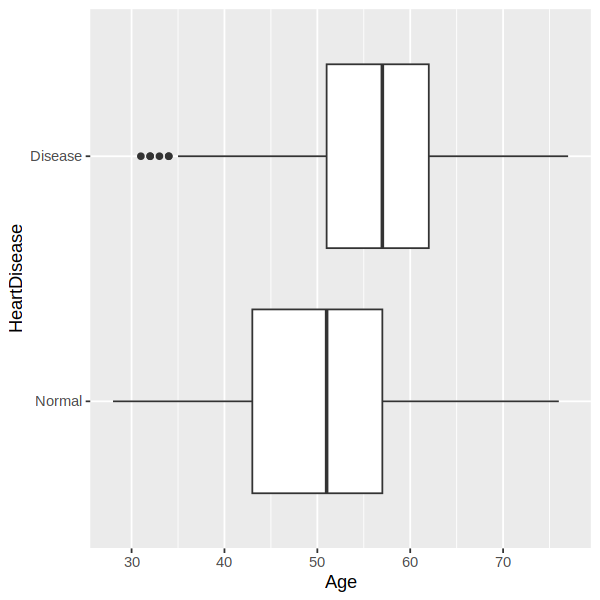

In [3]:
options(repr.plot.height = 5, repr.plot.width = 5)
age_heart<-ggplot(heart, aes(x=Age, y=HeartDisease)) + 
  geom_boxplot()
age_heart

The medians of the two boxes are not very close to each other, so it is reasonable to use age as one of the predictors.

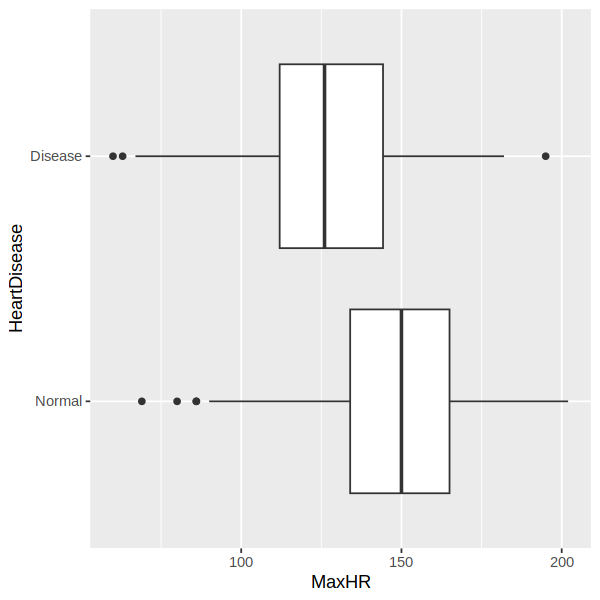

In [4]:
MaxHR_heart<-ggplot(heart, aes(x=MaxHR, y=HeartDisease)) + 
  geom_boxplot()
MaxHR_heart

The medians of the two boxes are not very close to each other, so it is reasonable to use MaxHR as one of the predictors.

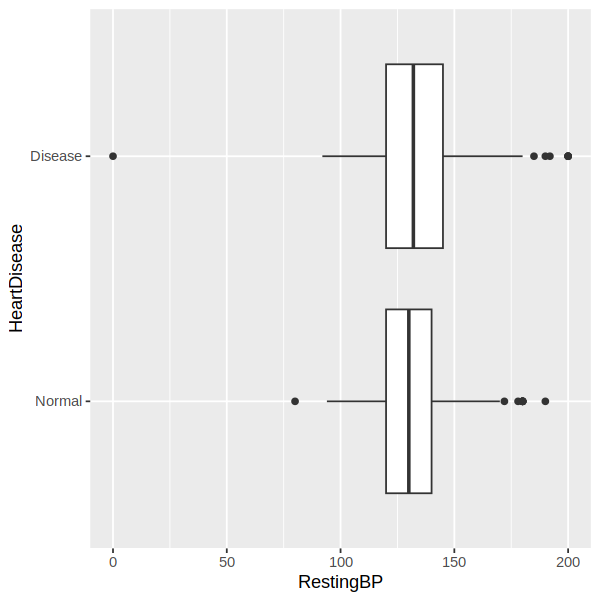

In [5]:
RestingBP_heart<-ggplot(heart, aes(x=RestingBP, y=HeartDisease)) + 
  geom_boxplot()
RestingBP_heart

The medians of the two boxes are very close to each other, which implies that the relationship between age and RestingBP is quite weak. Therefore, we choose not to include RestingBP as one of the predictors.

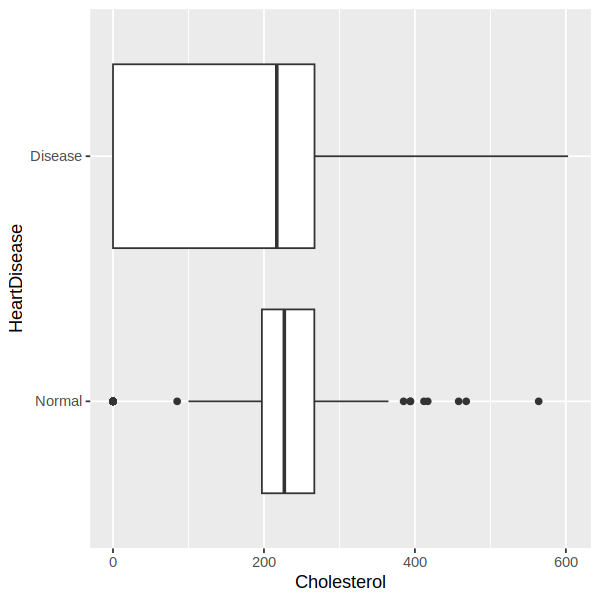

In [6]:
Cholesterol_heart<-ggplot(heart, aes(x=Cholesterol, y=HeartDisease)) + 
  geom_boxplot()
Cholesterol_heart

Although the medians of the two boxes are very close to each other, the upper box for having heart disease has a larger range than the lower box. Therefore, we include Cholesterol as one of the predictors.

In [7]:
heart_new<-heart|>select(Age,Cholesterol,MaxHR,HeartDisease)
head(heart_new)

Age,Cholesterol,MaxHR,HeartDisease
<dbl>,<dbl>,<dbl>,<fct>
40,289,172,Normal
49,180,156,Disease
37,283,98,Normal
48,214,108,Disease
54,195,122,Normal
39,339,170,Normal


In [8]:
set.seed(19)
heart_new_split<-initial_split(heart_new,prop=0.75,strata=HeartDisease)
heart_new_training<-training(heart_new_split)
heart_new_testing<-testing(heart_new_split)

In [9]:
stat_age<-heart_new_training|>group_by(HeartDisease)|>summarize(mean_age=mean(Age))
stat_cholesterol<-heart_new_training|>group_by(HeartDisease)|>summarize(mean_cholesterol=mean(Cholesterol))
stat_MaxHR<-heart_new_training|>group_by(HeartDisease)|>summarize(mean_MaxHR=mean(MaxHR))
stat_training<-heart_new_training|>group_by(HeartDisease)|>summarize(count=n())|>
    inner_join(stat_age)|>inner_join(stat_cholesterol)|>inner_join(stat_MaxHR)
stat_training

Joining with `by = join_by(HeartDisease)`
Joining with `by = join_by(HeartDisease)`
Joining with `by = join_by(HeartDisease)`


HeartDisease,count,mean_age,mean_cholesterol,mean_MaxHR
<fct>,<int>,<dbl>,<dbl>,<dbl>
Normal,307,50.57329,228.0912,147.9414
Disease,381,56.09186,174.0630,128.7034


### Methods: 
1.Based on the background information above, we aim to use age, cholesterol, and MaxHR to predict whether a future patient (with an unknown diagnosis) is potentially at risk of having heart disease.
2.Box plots are used to compare distributions when we have a categorical variable and a continuous variable. We can assess the relationship between the categorical factor 'HeartDisease' and three potential predictors by using three box plots.

### Expected outcomes and significance:
1.What do you expect to find? 
We expect to determine whether the classifier can accurately predict an individual's susceptibility to heart disease based on the given features.
2.What impact could such findings have?
Early detection is crucial in the management of heart disease. If the classifier proves effective, it could aid in identifying at-risk individuals earlier, potentially leading to timely interventions, better patient outcomes, and reduced healthcare costs.
3.What future questions could this lead to?
How can we further improve the accuracy of the classifier?
What additional features or medical tests could enhance the model's predictive power?
Can the model be integrated into routine medical check-ups for proactive heart disease screening?
Are there other medical conditions that can be predicted using a similar approach?

In [10]:
#install.packages("kknn")
heart_vfold<-vfold_cv(heart_new_training,v=5,strata=HeartDisease)

heart_recipe<-recipe(HeartDisease~Age+Cholesterol+MaxHR,data=heart_new_training)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

knn_spec<-nearest_neighbor(weight_func="rectangular",neighbors=tune())|>
    set_engine("kknn")|>
    set_mode("classification")

k_vals<-tibble(neighbors=seq(from=1,to=100,by=5))

knn_results<-workflow()|>
    add_recipe(heart_recipe)|>
    add_model(knn_spec)|>
    tune_grid(resamples=heart_vfold,grid=k_vals)|> 
    collect_metrics()

accuracies<- knn_results|>
    filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6511613,5,0.007909545,Preprocessor1_Model01
6,accuracy,binary,0.7080006,5,0.018464674,Preprocessor1_Model02
11,accuracy,binary,0.7311694,5,0.006976500,Preprocessor1_Model03
16,accuracy,binary,0.7239122,5,0.010518561,Preprocessor1_Model04
21,accuracy,binary,0.7311798,5,0.008271100,Preprocessor1_Model05
26,accuracy,binary,0.7312112,5,0.011505600,Preprocessor1_Model06
31,accuracy,binary,0.7268316,5,0.008628586,Preprocessor1_Model07
36,accuracy,binary,0.7340888,5,0.011836636,Preprocessor1_Model08
41,accuracy,binary,0.7312112,5,0.013625644,Preprocessor1_Model09


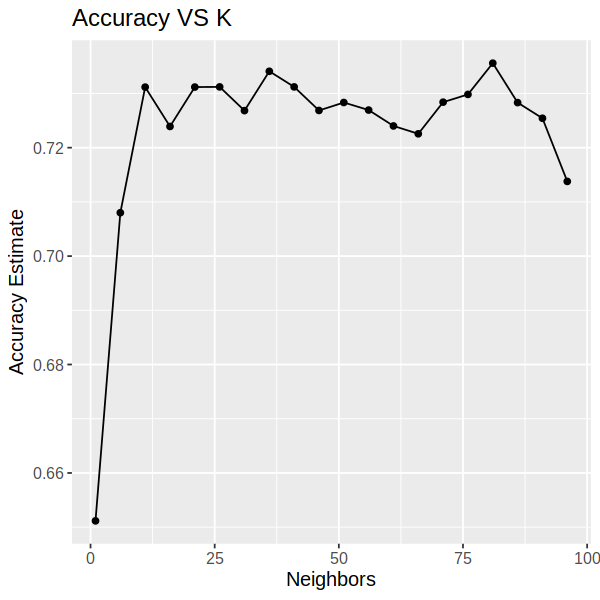

In [11]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 12))+
    ggtitle("Accuracy VS K")
accuracy_vs_k

We chose K=80 as our best K-value, because the accuracy of k=80 is the highest, and changing the value to a nearby one does not decrease accuracy too much.

In [12]:
best_knn_spec<-nearest_neighbor(weight_func="rectangular",neighbor=80)|> 
    set_engine("kknn")|> 
    set_mode("classification")

knn_fit<-workflow()|>
    add_recipe(heart_recipe)|> 
    add_model(best_knn_spec)|> 
    fit(data=heart_new_training)

heart_test_predictions<-predict(knn_fit,heart_new_testing)|>
    bind_cols(heart_new_testing)

heart_confusion_matrix<-heart_test_predictions|>
    conf_mat(truth= HeartDisease, estimate= .pred_class)

heart_accuracy<-heart_test_predictions|>
    metrics(truth = HeartDisease, estimate = .pred_class)|>
    filter(.metric == "accuracy")

heart_confusion_matrix
heart_accuracy

          Truth
Prediction Normal Disease
   Normal      65      29
   Disease     38      98

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7086957


##### Accuracy=0.708695=70.87%
##### Precision=98/(38+98)=0.720588=72.06%
##### Recall=98/(29+98)=0.771654=77.17%

### Evaluate the performance of our model:

#### Recall(77.17%):
The recall means that the model correctly identified 77.17% of individuals who actually have heart disease.  
If false negatives (missing actual cases of heart disease) are more concerning, we should prioritize recall and try to increase it. A higher recall means the model is better at capturing more instances of positive cases, reducing the chances of missing individuals who actually have heart disease. 

How to increase the recall???

##### Precision(72.06%):
The precision means that 72.06% of the individuals predicted to have heart disease actually have it. For example, hospitals (or other heart disease prediction institutions) need to bear the cost of incorrectly predicting heart disease, such as medical trouble and financial losses to patients. We should improve accuracy to reduce the cost of errors. If false positives (incorrectly predicting heart disease) are more costly, we should prioritize precision. Higher precision means a lower rate of false positives. 